<a href="https://colab.research.google.com/github/somesh-kb/Liver-Disease-India-Data/blob/main/Liver_Disease_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np 

In [53]:
file  = pd.read_csv('/content/Indian-Liver-Disease-Dataset.csv')
df = pd.DataFrame(file)

In [54]:
print(df.columns)

Index(['Age', 'Gender', 'TB', 'DB', 'AAP', 'SGPT', 'SGOT', 'TP', 'ALB', 'AG',
       'Class'],
      dtype='object')


In [55]:
print(df.dtypes)

Age         int64
Gender     object
TB        float64
DB        float64
AAP         int64
SGPT        int64
SGOT        int64
TP        float64
ALB       float64
AG        float64
Class       int64
dtype: object


In [56]:
print(df.shape)

(583, 11)


In [57]:
df['Gender'].value_counts()

Male      441
Female    142
Name: Gender, dtype: int64

In [58]:
print(df['Age'].value_counts())
print(df['Age'].describe())

60    34
45    25
50    23
42    21
38    21
      ..
10     1
8      1
84     1
6      1
90     1
Name: Age, Length: 72, dtype: int64
count    583.000000
mean      44.746141
std       16.189833
min        4.000000
25%       33.000000
50%       45.000000
75%       58.000000
max       90.000000
Name: Age, dtype: float64


44.74614065180103 16.18983330469438


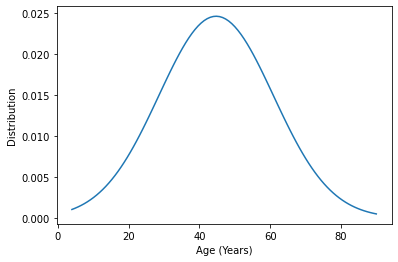

In [59]:
import scipy.stats 
import matplotlib.pyplot as plt 

mean = df['Age'].mean()
std = df['Age'].std()

print(mean,std)

min = 4
max= 90 

x = np.linspace(min,max,100)
y = scipy.stats.norm.pdf(x,mean,std)

plt.plot(x,y)
plt.xlabel('Age (Years)')
plt.ylabel('Distribution')
plt.show()

In [60]:
gender = pd.get_dummies(df['Gender'])

print(gender)

df_new = pd.concat([gender,df],axis=1,join='inner')

print(df_new.columns)

     Female  Male
0         1     0
1         0     1
2         0     1
3         0     1
4         0     1
..      ...   ...
578       0     1
579       0     1
580       0     1
581       0     1
582       0     1

[583 rows x 2 columns]
Index(['Female', 'Male', 'Age', 'Gender', 'TB', 'DB', 'AAP', 'SGPT', 'SGOT',
       'TP', 'ALB', 'AG', 'Class'],
      dtype='object')


In [61]:
df_new.drop('Gender',inplace=True,axis=1)

print(df_new.columns)

Index(['Female', 'Male', 'Age', 'TB', 'DB', 'AAP', 'SGPT', 'SGOT', 'TP', 'ALB',
       'AG', 'Class'],
      dtype='object')


##  Correlation between the features: Pearson Correlation 

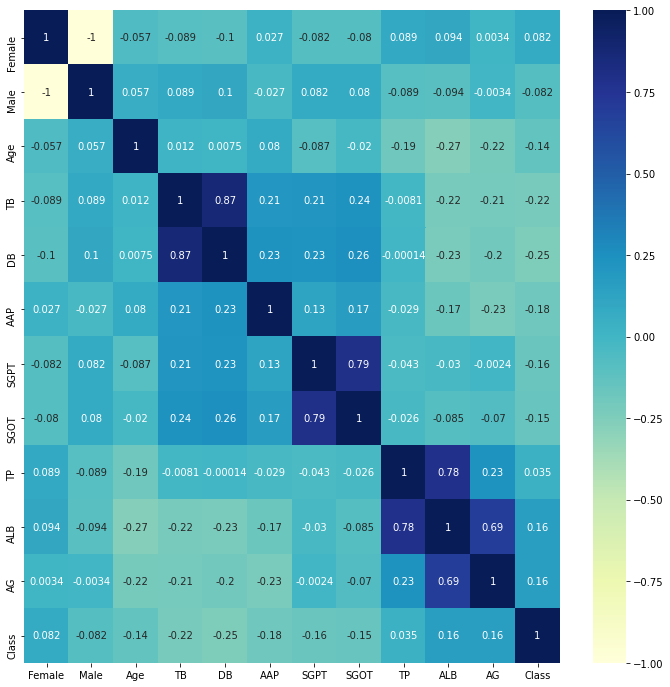

In [62]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df_new.corr(),cmap='YlGnBu',annot=True)
plt.show()

**Feature Selection** : Based on the above correlation matrix, we selected independent features for which the Pearson correlation (P) is  -0.3 < P < 0.3 between two independent features. 

In [63]:
X = df_new[['Female', 'Male', 'Age', 'TB', 'AAP', 'SGPT', 'TP']]
            
Y = df_new['Class']

# To verify the correlation

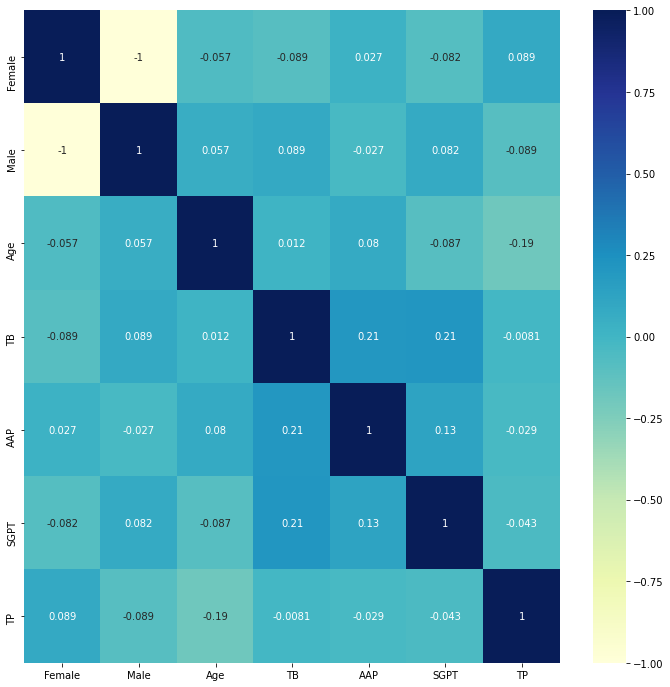

In [64]:
plt.figure(figsize=(12,12))
sns.heatmap(X.corr(),annot=True,cmap='YlGnBu')
plt.show()

# Split the whole dataset into training and test data

In [65]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=21)

print(X_train.shape)

(437, 7)


Two classification models employed: **1) RandomForestClassfier** --> A tree based model
**2) Support Vector Machine Classfier** --> Distance based model 

Hyperparameter optimization performed using two methods:

1) RandomizedSearchCV

2) Bayesian Optimization using **"Hyperopt"**


# **RandomizedSearchCV** for hyperparameter tuning

---




In [66]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(random_state=11)

print(rf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)>


In [67]:
from sklearn.model_selection import RandomizedSearchCV 

bootstrap = [True,False]

criterion = ['gini', 'entropy']

max_depth = [int(x) for x in range(2,91,1)]

max_features = ['auto', 'sqrt', 'log2']

#min_impurity_decrease = [j for j in np.arange(0,0.5,0.1)]

#min_samples_split = [int(x) for x in np.arange(2,11,1)]

max_leaf_nodes = [int(x) for x in np.arange(2,41,1)]

n_estimators = [int(x) for x in np.arange(50,1001,10)]

param_grid = {'bootstrap':bootstrap,'criterion':criterion,'n_estimators':n_estimators, 
              'max_depth':max_depth,'max_features':max_features,'max_leaf_nodes':max_leaf_nodes}

rs_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, n_jobs=-1, 
                           random_state=21, return_train_score=True, cv=10)

rs_cv.fit(X_train,Y_train)

print(rs_cv.best_params_)

{'n_estimators': 850, 'max_leaf_nodes': 27, 'max_features': 'sqrt', 'max_depth': 48, 'criterion': 'gini', 'bootstrap': False}


In [78]:
rf = RandomForestClassifier(n_estimators=850,max_leaf_nodes=27,max_features='sqrt', 
                            max_depth= 48, criterion='gini',bootstrap=False)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)

In [79]:
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

print(classification_report(Y_test,Y_pred))

print(confusion_matrix(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.82      0.92      0.87       115
           2       0.44      0.23      0.30        31

    accuracy                           0.77       146
   macro avg       0.63      0.57      0.58       146
weighted avg       0.74      0.77      0.74       146

[[106   9]
 [ 24   7]]


# **SVM Classifier**

In [80]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler()

Xsc_train = std_scale.fit_transform(X_train)
Xsc_test = std_scale.fit_transform(X_test)
 

In [81]:
from sklearn.svm import SVC 

svc = SVC()


print(svc.get_params)

<bound method BaseEstimator.get_params of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)>


In [82]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']#, 'precomputed']

degree=[int(x) for x in np.arange(2,7,1)]

gamma = ['auto','scale']#, 'ball_tree', 'kd_tree', 'brute']

#leaf_size = (int(x) for x in np.arange(10,102,2))

svm_param = {'kernel':kernel,'degree':degree,'gamma':gamma}#,'algorithm':algorithm, 'leaf_size':leaf_size}

rs_cv = RandomizedSearchCV(estimator=svc,param_distributions=svm_param,
                           return_train_score=True,random_state=21)

rs_cv.fit(Xsc_train,Y_train)

print(rs_cv.best_params_)

{'kernel': 'poly', 'gamma': 'scale', 'degree': 3}


In [83]:
svc = SVC(kernel='poly', gamma = 'scale', degree=3)

svc.fit(Xsc_train,Y_train)

Y_pred = svc.predict(Xsc_test)

In [84]:
print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))

[[110   5]
 [ 28   3]]
              precision    recall  f1-score   support

           1       0.80      0.96      0.87       115
           2       0.38      0.10      0.15        31

    accuracy                           0.77       146
   macro avg       0.59      0.53      0.51       146
weighted avg       0.71      0.77      0.72       146



# **Bayesian Optimization** of hyperparameter tuning

In [85]:
!pip install scikit-optimize

In [86]:
from skopt import BayesSearchCV

In [87]:
bs_cv = BayesSearchCV(estimator=rf,search_spaces=param_grid, n_iter=100,n_jobs=-1,
                      cv=10,random_state=111,return_train_score=True)
bs_cv.fit(X_train,Y_train)
print(bs_cv.best_params_)

OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 87), ('max_features', 'log2'), ('max_leaf_nodes', 30), ('n_estimators', 570)])


In [88]:
rf = RandomForestClassifier(bootstrap= False,criterion= 'gini', max_depth=87, 
                            max_features= 'log2', max_leaf_nodes= 30, n_estimators= 570)

rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)

In [90]:
print(classification_report(Y_test,Y_pred))

print(confusion_matrix(Y_test,Y_pred))

              precision    recall  f1-score   support

           1       0.82      0.92      0.87       115
           2       0.44      0.23      0.30        31

    accuracy                           0.77       146
   macro avg       0.63      0.57      0.58       146
weighted avg       0.74      0.77      0.74       146

[[106   9]
 [ 24   7]]
